In [ ]:
import shutil

# Hàm cho thao tác insert

In [ ]:
'''
CREATE OR REPLACE FUNCTION InsertRandomRectangles (n INTEGER DEFAULT 100000)
        RETURNS Geometry
        AS $$
DECLARE
	t timestamptz := clock_timestamp();
        i INTEGER := 0;
        Xmin INTEGER := 0;
	Xmax INTEGER := 1;
	Ymin INTEGER := 0;
	Ymax INTEGER := 1;    
BEGIN   
        WHILE i < n LOOP
                i = i + 1;
                Xmin = random()*500000;
                Xmax = random()*100+Xmin+1;
                Ymin = random()*500000;
                Ymax = random()*100+Ymin+1;
                INSERT into test values (ST_MakeEnvelope(Xmin, Xmax, Ymin, Ymax));
        END LOOP;
	raise notice 'Time spent: %', clock_timestamp() - t;
	RETURN NULL;
END; 
$$ LANGUAGE plpgsql;
'''

Overwriting main.cpp


In [ ]:
# Viết hàm trên vào file .txt hoặc sql, sau đó chạy file trong PostgreSQL 1 lần duy nhất để tạo hàm
# Sử dụng lệnh sau để insert 1tr phần tử: SELECT InsertRandomRectangles(1000000);
# Mỗi phần tử là 1 polygon, cụ thể là hình chữ nhật, được khởi tạo bởi 4 giá trị (Xmin, Xmax, Ymin, Ymax)
# Tọa độ mỗi hình chữ nhật dao động từ 0-500000, chiều dài và rộng dao động từ 1-101

In [ ]:
# https://postgis.net/docs/ST_MakeEnvelope.html
# https://trac.osgeo.org/postgis/wiki/UserWikiRandomPoint

# Tạo file cho thao tác delete
Delete 1 polygon ngẫu nhiên trong table. Thực hiện đo 100 lần và lấy thời gian đo được chia 100.

In [ ]:
%%writefile main.cpp
#include <iostream>
#include <fstream>
#include <stdlib.h>
#include <time.h>
using namespace std;
int main() {
  fstream f;
  srand (time(NULL));
  f.open("delete.txt",ios::out);
  f<<"do $$\n";
  f<<"declare t timestamptz := clock_timestamp();\n";
  f<<"begin\n";

  for(long i=0; i<100; i++) {
    int  Xmin = rand()%500000, Xmax = rand()%100 + Xmin + 1, Ymin = rand()%500000, Ymax = rand()%100 + Ymin + 1;
    f<<"DELETE FROM test WHERE ST_EQUALS(rectangle, ST_MakeEnvelope (" << Xmin << ", " << Xmax << ", " << Ymin << ", " << Ymax << "));\n";    
  }
  f<<"raise notice 'time spent=%', clock_timestamp() - t;\n";
  f<<"end\n";
  f<<"$$ language plpgsql";
  f.close();
  return 0;
}

Overwriting main.cpp


In [ ]:
!g++ main.cpp -o main -std=c++11

In [ ]:
# Tạo 50 file để đo từ 100k-5tr phần tử (step=100k)
!mkdir '/content/delete'
for i in range (50):
  !./main
  shutil.move('/content/delete.txt','/content/delete/delete' + str(i+1) + '.txt')
!zip -qr '/content/delete.zip' '/content/delete'

# Tạo file cho thao tác update
Update 1 polygon ngẫu nhiên thành 1 polygon ngẫu nhiên khác. Thực hiện đo 100 lần và lấy thời gian đo được chia 100.

In [ ]:
%%writefile main.cpp
#include <iostream>
#include <fstream>
#include <stdlib.h>
#include <time.h>
using namespace std;
int main() {
  fstream f;
  srand (time(NULL));
  f.open("update.txt",ios::out);
  f<<"do $$\n";
  f<<"declare t timestamptz := clock_timestamp();\n";
  f<<"begin\n";

  for(long i=0; i<100; i++){
    int  Xmin = rand()%500000, Xmax = rand()%100 + Xmin + 1, Ymin = rand()%500000, Ymax = rand()%100 + Ymin + 1;
    int  X1min = rand()%500000, X1max = rand()%100 + X1min + 1, Y1min = rand()%500000, Y1max = rand()%100 + Y1min + 1;
    f<<"UPDATE test SET rectangle = ST_MakeEnvelope (" << X1min << ", " << X1max << ", " << Y1min << ", " << Y1max << ") "
    << "WHERE ST_EQUALS(rectangle, ST_MakeEnvelope (" << Xmin << ", " << Xmax << ", " << Ymin << ", " << Ymax << "));\n";    
  }
  f<<"raise notice 'time spent=%', clock_timestamp() - t;\n";
  f<<"end\n";
  f<<"$$ language plpgsql";
  f.close();
  return 0;
}

Overwriting main.cpp


In [ ]:
!g++ main.cpp -o main -std=c++11


In [ ]:
# Tạo 50 file để đo từ 100k-5tr phần tử (step=100k)
!mkdir '/content/update'
for i in range (50):
  !./main
  shutil.move('/content/update.txt','/content/update/update' + str(i+1) + '.txt')
!zip -qr '/content/update.zip' '/content/update'

# Tạo file cho thao tác search với hàm ST_Touches
Tìm các polygons trong table tiếp xúc với 1 polygon ngẫu nhiên cho trước (dùng hàm ST_Touches). Thực hiện đo 1 lần.

In [ ]:
%%writefile main.cpp
#include <iostream>
#include <fstream>
#include <stdlib.h>
#include <time.h>
using namespace std;
int main() {
  fstream f;
  f.open("touch.txt",ios::out);
  f<<"do $$\n";
  f<<"declare t timestamptz := clock_timestamp();\n";
  f<<"begin\n";

  int  Xmin = rand()%500000, Xmax = rand()%100 + Xmin + 1, Ymin = rand()%500000, Ymax = rand()%100 + Ymin + 1; 
  f<<"PERFORM * FROM test WHERE ST_Touches(rectangle, ST_MakeEnvelope (" << Xmin << ", " << Xmax << ", " << Ymin << ", " << Ymax << "));\n";

  
  f<<"raise notice 'time spent=%', clock_timestamp() - t;\n";
  f<<"end\n";
  f<<"$$ language plpgsql";
  f.close();
  return 0;
}

Overwriting main.cpp


In [ ]:
!g++ main.cpp -o main -std=c++11

In [ ]:
# Tạo 50 file để đo từ 100k-5tr phần tử (step=100k)
!mkdir '/content/touch'
for i in range (50):
  !./main
  shutil.move('/content/touch.txt','/content/touch/touch' + str(i+1) + '.txt')
!zip -qr '/content/touch.zip' '/content/touch'

# Tạo file cho thao tác search với hàm ST_DWithin
Tìm các polygons nằm trong phạm vi bán kính bằng 10 so với một polygon ngẫu nhiên cho trước (dùng hàm ST_DWithin). Thực hiện đo 1 lần.

In [ ]:
%%writefile main.cpp
#include <iostream>
#include <fstream>
#include <stdlib.h>
#include <time.h>
using namespace std;
int main() {
  fstream f;
  srand (time(NULL));
  f.open("dwithin.txt",ios::out);
  f<<"do $$\n";
  f<<"declare t timestamptz := clock_timestamp();\n";
  f<<"begin\n";

  int  Xmin = rand()%500000, Xmax = rand()%100 + Xmin + 1, Ymin = rand()%500000, Ymax = rand()%100 + Ymin + 1; 
  f<<"PERFORM * FROM test WHERE ST_DWithin(rectangle, ST_MakeEnvelope (" << Xmin << ", " << Xmax << ", " << Ymin << ", " << Ymax << "), 10);\n";
  
  f<<"raise notice 'time spent=%', clock_timestamp() - t;\n";
  f<<"end\n";
  f<<"$$ language plpgsql";
  f.close();
  return 0;
}

Overwriting main.cpp


In [ ]:
!g++ main.cpp -o main -std=c++11

In [ ]:
# Tạo 50 file để đo từ 100k-5tr phần tử (step=100k)
!mkdir '/content/dwithin'
for i in range (50):
  !./main
  shutil.move('/content/dwithin.txt','/content/dwithin/dwithin' + str(i+1) + '.txt')
!zip -qr '/content/dwithin.zip' '/content/dwithin'

In [ ]:
#!rm -r '/content/dwithin'

In [ ]:
# https://stackoverflow.com/questions/35706060/how-to-get-execution-time-in-postgres
# https://gis.stackexchange.com/questions/58605/which-function-for-creating-a-point-in-postgis

# Đo RAM và Disk của PostgreSQL

In [ ]:
resource=pd.read_csv("https://raw.githubusercontent.com/UIT-19521183/CS523.L21/main/R-Tree/RAM%20and%20Disk/RAM%20and%20Disk.csv")
resource.head(5)

,Size,RAM(KB),Disk(KB)
0,2000000,321600,6251180.105
1,2000000,321868,6251180.105
2,2000000,322060,6251180.105
3,2000000,322284,6251180.105
4,2000000,322532,6251180.105


In [ ]:
resource=resource.groupby('Size', as_index = False).mean()
resource

,Size,RAM(KB),Disk(KB)
0,2000000,324882.000000,6.251180e+06
1,4000000,307058.352941,6.453844e+06
2,6000000,310616.761905,6.662283e+06
3,8000000,298848.000000,6.711508e+06
4,10000000,369534.720000,6.915780e+06
5,12000000,394900.320000,7.116564e+06
6,14000000,342039.142857,7.623429e+06
7,16000000,355385.333333,7.825060e+06
8,18000000,355817.411765,8.024093e+06
9,20000000,374162.000000,8.222133e+06


In [ ]:
size=np.array(resource['Size']).reshape(-1,1)
ram=np.array(resource['RAM(KB)'])
disk=np.array(resource['Disk(KB)'])

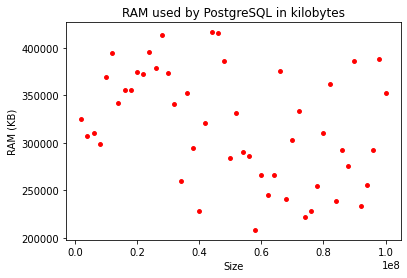

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.set_title('RAM used by PostgreSQL in kilobytes', size=12)
ax.set_xlabel('Size')
ax.set_ylabel('RAM (KB)')
plt.scatter(size, ram, c='r', s=15)

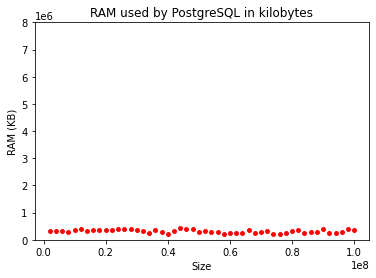

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.set_title('RAM used by PostgreSQL in kilobytes', size=12)
ax.set_xlabel('Size')
ax.set_ylabel('RAM (KB)')
ax.set_ylim([0,8000000]) # từ 0 đến 8GB theo KB
plt.scatter(size, ram, c='r', s=15)

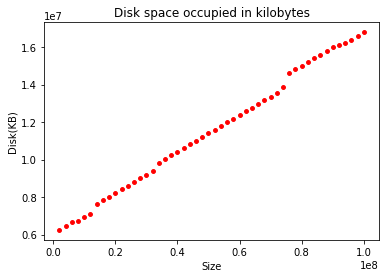

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.set_title('Disk space occupied in kilobytes', size=12)
ax.set_xlabel('Size')
ax.set_ylabel('Disk(KB)')
plt.scatter(size, disk, c='r', s=15)

In [ ]:
'''
while(Get-Process postgres -ErrorAction SilentlyContinue) {
     $ram = (Get-Process postgres| Measure-Object WorkingSet -sum).sum / 1KB
     $disk = (Get-ChildItem -force "C:\Program Files\PostgreSQL\13\data" -Recurse -ErrorAction SilentlyContinue| measure Length -sum).sum / 1KB
     Write-Output "$ram, $disk" >> "C:\Users\Thuy An\Desktop\ram.txt"
     Start-Sleep -s 0.5
}
'''
# Chạy lệnh trên bằng Windows PowerShell để đo ram và disk

In [ ]:
# https://docs.microsoft.com/en-us/powershell/module/microsoft.powershell.management/get-process?view=powershell-7.1
# https://docs.microsoft.com/en-us/dotnet/api/system.diagnostics.process.workingset?view=net-5.0
# https://docs.microsoft.com/en-us/powershell/module/microsoft.powershell.management/get-childitem?view=powershell-7.1&viewFallbackFrom=powershell-6